1. IMPORTING LIBRARIES

In [1]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

2024-05-20 10:57:51.712409: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 10:57:51.761838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 10:57:51.761875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 10:57:51.763063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 10:57:51.769859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 10:57:51.770673: I tensorflow/core/platform/cpu_feature_guard.cc:1

2. LOADING THE DATA

In [2]:
# Loading Training Data
training_dir = './data/Train_Images/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    label_dir = os.path.join(training_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                training_paths.append(file_path)
                train_labels.append(label)

random.shuffle(training_paths)
random.shuffle(train_labels)

# show an example of the list
print(training_paths[0])

./data/Train_Images/Fake/IMG_1787.jpg


In [3]:
len(training_paths)

86

In [4]:
# Loading Testing/Validation Data
test_dir = './data/Test_Images/'
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                test_paths.append(file_path)
                test_labels.append(label)

random.shuffle(test_paths)
random.shuffle(test_labels)

# show an example of the list
print(test_paths[0])

./data/Test_Images/Fake/_100030076_nairabadnotes1-2.jpg


In [5]:
len(test_paths)

53

In [6]:
labels = [label for label in os.listdir(training_dir) if not label.startswith('.')]

labels

['Fake', 'Real']

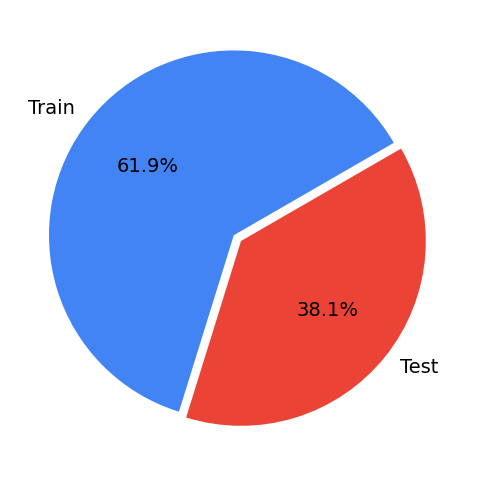

In [7]:
# Ratio of Training Data to Testing Data
plt.figure(figsize=(14,6))
colors = ['#4284f4', '#eb4335']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

3. DATA AUGMENTATION

In [8]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

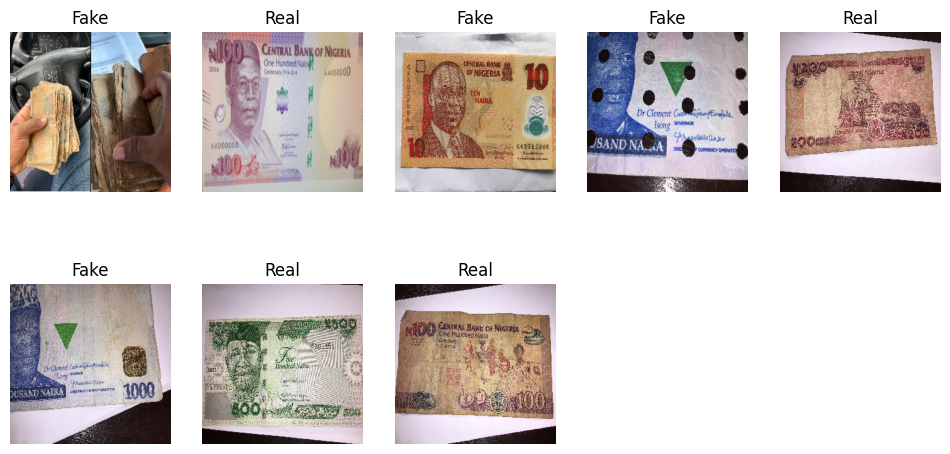

In [51]:
i = random.randint(0,len(training_paths))
images = open_images(training_paths[50:59])
xlabels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 5, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

4. DATA GENERATOR

In [30]:
def data_gen(data_paths, batch_size=8):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    while True:
        # Shuffle the data paths for each epoch (if needed)
        # np.random.shuffle(data_paths)
    
        
        for i in range(0, len(data_paths), batch_size):
            paths = data_paths[i:i+batch_size]
            images = open_images(paths)
            labels = get_labels(paths)
            yield images, np.array(labels)

5. BUILDING THE ResNet152V2 MODEL

In [31]:
# Loading the Pre-Trained Model (ResNet152V2)

base_model = ResNet152V2(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [32]:
len (base_model.layers)

564

In [33]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last ResNet152V2 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [34]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax')) # num labels = 2

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_2 (Dropout)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               16777344  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 75109250 (286.52 MB)
Trainable params: 1

6. TRAINING THE MODEL

In [35]:

model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [37]:
# Training the Model

batch_size=8

history = model.fit(data_gen(training_paths), 
epochs=5,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/5
10/10 [==============================] - 23s 2s/step - loss: 0.9150 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.1587 - val_sparse_categorical_accuracy: 0.9375
Epoch 2/5
10/10 [==============================] - 18s 2s/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.1691 - val_sparse_categorical_accuracy: 0.9556
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 0.0059 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9778
Epoch 4/5
10/10 [==============================] - 19s 2s/step - loss: 3.6680e-07 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0900 - val_sparse_categorical_accuracy: 0.9778
Epoch 5/5
10/10 [==============================] - 18s 2s/step - loss: 7.5040e-07 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0610 - val_sparse_categorical_accuracy: 0.9556


7. EVALUATING THE MODEL

In [38]:
evaluation = model.evaluate(
    data_gen(test_paths, batch_size=batch_size),  # Ensure the same batch size as during training
    steps=len(test_paths) // batch_size  # Assuming the test set size is a multiple of the batch size
)
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])


6/6 [==============================] - 6s 980ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9583
Test Loss: 0.05718046426773071
Test Accuracy: 0.9583333134651184


In [39]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
# plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

1/1 [==============================] - 2s 2s/step
Predicted: Real
Actual: Real


In [40]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


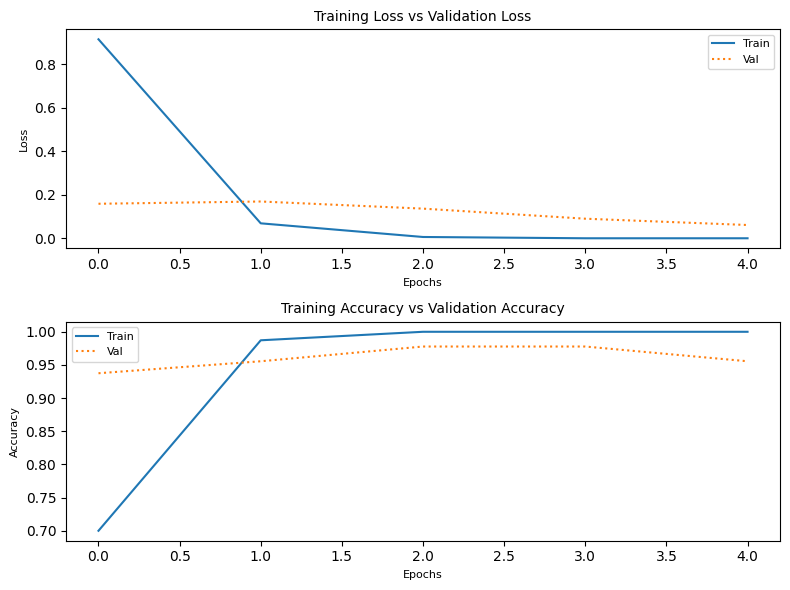

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Adjust the figure size as needed

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].set_title('Training Loss vs Validation Loss', fontsize=10)
axs[0].set_xlabel('Epochs', fontsize=8)
axs[0].set_ylabel('Loss', fontsize=8)
axs[0].legend(['Train', 'Val'], fontsize=8)

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].set_title('Training Accuracy vs Validation Accuracy', fontsize=10)
axs[1].set_xlabel('Epochs', fontsize=8)
axs[1].set_ylabel('Accuracy', fontsize=8)
axs[1].legend(['Train', 'Val'], fontsize=8)

plt.tight_layout()  
plt.show()


8. CLASSIFICATION REPORT AND CONFUSION MATRIX

In [42]:
# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data batches
for paths_batch, labels_batch in data_gen(test_paths, batch_size=batch_size):
    # Predict batch
    predictions_batch = model.predict(paths_batch)
    # Convert predictions to class labels
    predictions_classes_batch = np.argmax(predictions_batch, axis=1)
    # Append true and predicted labels to lists
    y_true.extend(labels_batch)
    y_pred.extend(predictions_classes_batch)

    # Break the loop if all test data has been processed
    if len(y_true) >= len(test_paths):
        break

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
target_names = labels  # Assuming you have defined 'labels' somewhere
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=target_names))


1/1 [==============================] - 1s 589ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.93      0.93        15
        Real       0.97      0.97      0.97        38

    accuracy                           0.96        53
   macro avg       0.95      0.95      0.95        53
weighted avg       0.96      0.96      0.96        53



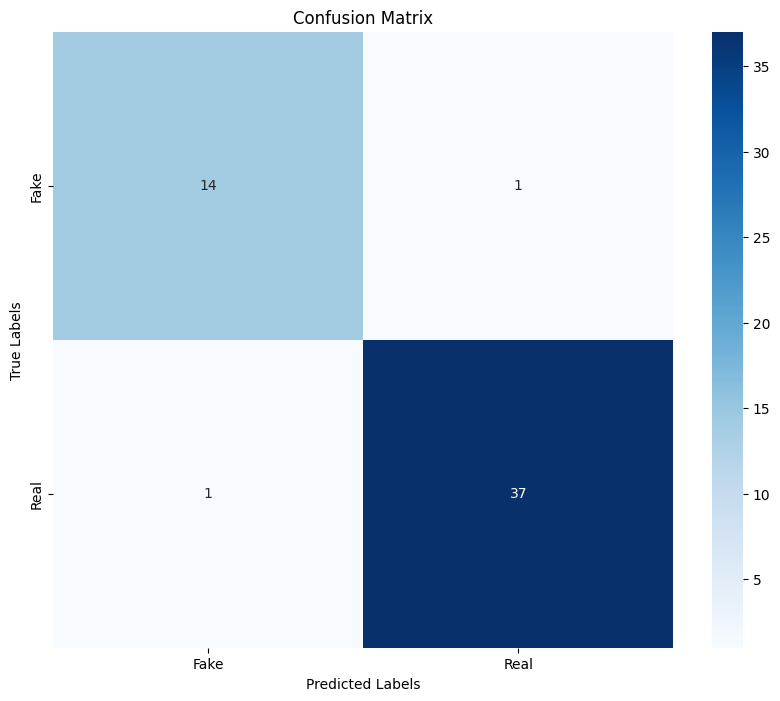

In [43]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

9. SAVING THE MODEL

In [45]:
# Save the model in HDF5 format
model.save('naira_model.h5')

# Save the model in TensorFlow SavedModel format
model.save('naira_model')

/home/david/Desktop/Adeolu/app/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: naira_model/assets


INFO:tensorflow:Assets written to: naira_model/assets


In [44]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model
with open('naira.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd_v0ar8y/assets


INFO:tensorflow:Assets written to: /tmp/tmpd_v0ar8y/assets
2024-05-20 11:40:19.892597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-20 11:40:19.892643: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-20 11:40:19.892822: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd_v0ar8y
2024-05-20 11:40:19.971924: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-20 11:40:19.971966: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpd_v0ar8y
2024-05-20 11:40:20.200804: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-20 11:40:21.954573: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpd_v0ar8y
2024-05-20 11:40:22.504478: I tensorflow/cc/saved_model/loader.cc:316] SavedModel